# Method 9 - Best Ideas DGTW Selection

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)


monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

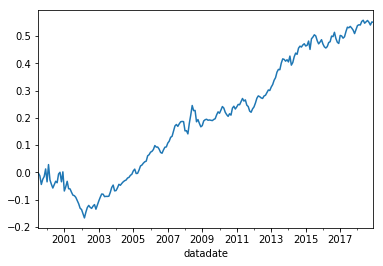

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.012526
2000-12-31   -0.010502
2001-12-31   -0.133018
2002-12-31    0.013571
2003-12-31    0.058863
2004-12-31    0.065181
2005-12-31    0.072275
2006-12-31    0.026632
2007-12-31    0.084870
2008-12-31   -0.015990
2009-12-31    0.047037
2010-12-31    0.008473
2011-12-31    0.000297
2012-12-31    0.054779
2013-12-31    0.086664
2014-12-31    0.041486
2015-12-31    0.010101
2016-12-31   -0.009279
2017-12-31    0.034883
2018-12-31    0.017320
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     8.282
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.96e-06
Time:                        20:14:21   Log-Likelihood:                 682.26
No. Observations:                 234   AIC:                            -1355.
Df Residuals:                     229   BIC:                            -1337.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.076      0.283      -0.001       0.003
mktrf          0.0402      0.025      1.626      0.105      -0.009       0.089
me             0.1425      0.029      4.957      0.000       0.086       0.199
ia            -0.0932      0.044     -2.133      0.034      -0.179      -0.007
roe            0.1300      0.037      3.475      0.001       0.056       0.204
==============================================================================
Omnibus:                       65.633   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.322
Skew:                          -1.138   Prob(JB):                     3.21e-49
Kurtosis:                       7.210   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     3.985
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00381
Time:                        20:14:21   Log-Likelihood:                 682.26
No. Observations:                 234   AIC:                            -1355.
Df Residuals:                     229   BIC:                            -1337.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.945      0.345      -0.001       0.003
mktrf          0.0402      0.029      1.374      0.170      -0.017       0.097
me             0.1425      0.056      2.564      0.010       0.034       0.251
ia            -0.0932      0.095     -0.985      0.325      -0.279       0.092
roe            0.1300      0.048      2.722      0.006       0.036       0.224
==============================================================================
Omnibus:                       65.633   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.322
Skew:                          -1.138   Prob(JB):                     3.21e-49
Kurtosis:                       7.210   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     4.064
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00334
Time:                        20:14:21   Log-Likelihood:                 682.26
No. Observations:                 234   AIC:                            -1355.
Df Residuals:                     229   BIC:                            -1337.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.808      0.419      -0.001       0.003
mktrf          0.0402      0.023      1.765      0.078      -0.004       0.085
me             0.1425      0.058      2.451      0.014       0.029       0.256
ia            -0.0932      0.082     -1.136      0.256      -0.254       0.068
roe            0.1300      0.043      3.048      0.002       0.046       0.214
==============================================================================
Omnibus:                       65.633   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.322
Skew:                          -1.138   Prob(JB):                     3.21e-49
Kurtosis:                       7.210   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.644
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00343
Time:                        20:14:21   Log-Likelihood:                 675.45
No. Observations:                 234   AIC:                            -1339.
Df Residuals:                     228   BIC:                            -1318.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.697      0.091      -0.000       0.003
mktrf          0.0126      0.026      0.494      0.622      -0.038       0.063
smb            0.0974      0.034      2.889      0.004       0.031       0.164
hml           -0.0846      0.040     -2.127      0.034      -0.163      -0.006
rmw            0.0145      0.045      0.323      0.747      -0.074       0.103
cma            0.0422      0.057      0.739      0.461      -0.070       0.155
==============================================================================
Omnibus:                       70.234   Durbin-Watson:                   2.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.704
Skew:                          -1.094   Prob(JB):                     4.66e-74
Kurtosis:                       8.463   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.498
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.191
Time:                        20:14:21   Log-Likelihood:                 675.45
No. Observations:                 234   AIC:                            -1339.
Df Residuals:                     228   BIC:                            -1318.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.908      0.056   -4.35e-05       0.003
mktrf          0.0126      0.026      0.490      0.624      -0.038       0.063
smb            0.0974      0.050      1.934      0.053      -0.001       0.196
hml           -0.0846      0.039     -2.155      0.031      -0.161      -0.008
rmw            0.0145      0.059      0.244      0.807      -0.102       0.131
cma            0.0422      0.114      0.370      0.712      -0.182       0.266
==============================================================================
Omnibus:                       70.234   Durbin-Watson:                   2.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.704
Skew:                          -1.094   Prob(JB):                     4.66e-74
Kurtosis:                       8.463   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.702
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.135
Time:                        20:14:21   Log-Likelihood:                 675.45
No. Observations:                 234   AIC:                            -1339.
Df Residuals:                     228   BIC:                            -1318.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.717      0.086      -0.000       0.003
mktrf          0.0126      0.025      0.504      0.614      -0.036       0.062
smb            0.0974      0.044      2.237      0.025       0.012       0.183
hml           -0.0846      0.040     -2.107      0.035      -0.163      -0.006
rmw            0.0145      0.061      0.240      0.811      -0.104       0.133
cma            0.0422      0.120      0.351      0.726      -0.194       0.278
==============================================================================
Omnibus:                       70.234   Durbin-Watson:                   2.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.704
Skew:                          -1.094   Prob(JB):                     4.66e-74
Kurtosis:                       8.463   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     23.55
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.55e-16
Time:                        20:14:21   Log-Likelihood:                 706.76
No. Observations:                 234   AIC:                            -1404.
Df Residuals:                     229   BIC:                            -1386.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.134      0.258      -0.001       0.002
mktrf          0.0771      0.020      3.762      0.000       0.037       0.117
smb            0.0379      0.026      1.482      0.140      -0.012       0.088
hml           -0.0112      0.025     -0.440      0.661      -0.061       0.039
umd            0.1417      0.017      8.502      0.000       0.109       0.175
==============================================================================
Omnibus:                       34.197   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.172
Skew:                          -0.720   Prob(JB):                     3.51e-16
Kurtosis:                       5.286   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     12.35
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.09e-09
Time:                        20:14:21   Log-Likelihood:                 706.76
No. Observations:                 234   AIC:                            -1404.
Df Residuals:                     229   BIC:                            -1386.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.896      0.370      -0.001       0.003
mktrf          0.0771      0.021      3.594      0.000       0.035       0.119
smb            0.0379      0.037      1.034      0.301      -0.034       0.110
hml           -0.0112      0.034     -0.328      0.743      -0.078       0.056
umd            0.1417      0.033      4.278      0.000       0.077       0.207
==============================================================================
Omnibus:                       34.197   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.172
Skew:                          -0.720   Prob(JB):                     3.51e-16
Kurtosis:                       5.286   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     16.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-11
Time:                        20:14:21   Log-Likelihood:                 706.76
No. Observations:                 234   AIC:                            -1404.
Df Residuals:                     229   BIC:                            -1386.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.801      0.423      -0.001       0.003
mktrf          0.0771      0.016      4.798      0.000       0.046       0.109
smb            0.0379      0.027      1.424      0.155      -0.014       0.090
hml           -0.0112      0.034     -0.331      0.741      -0.077       0.055
umd            0.1417      0.032      4.419      0.000       0.079       0.205
==============================================================================
Omnibus:                       34.197   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.172
Skew:                          -0.720   Prob(JB):                     3.51e-16
Kurtosis:                       5.286   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     7.040
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.17e-05
Time:                        20:14:22   Log-Likelihood:                 327.27
No. Observations:                 120   AIC:                            -644.5
Df Residuals:                     115   BIC:                            -630.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.250      0.803      -0.003       0.003
mktrf          0.0747      0.042      1.793      0.076      -0.008       0.157
me             0.1956      0.041      4.753      0.000       0.114       0.277
ia            -0.0854      0.064     -1.325      0.188      -0.213       0.042
roe            0.2068      0.057      3.625      0.000       0.094       0.320
==============================================================================
Omnibus:                       27.198   Durbin-Watson:                   2.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.414
Skew:                          -1.031   Prob(JB):                     1.38e-10
Kurtosis:                       5.199   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     6.250
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000138
Time:                        20:14:22   Log-Likelihood:                 327.27
No. Observations:                 120   AIC:                            -644.5
Df Residuals:                     115   BIC:                            -630.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.200      0.841      -0.004       0.003
mktrf          0.0747      0.047      1.597      0.110      -0.017       0.166
me             0.1956      0.067      2.925      0.003       0.065       0.327
ia            -0.0854      0.114     -0.750      0.453      -0.308       0.138
roe            0.2068      0.061      3.404      0.001       0.088       0.326
==============================================================================
Omnibus:                       27.198   Durbin-Watson:                   2.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.414
Skew:                          -1.031   Prob(JB):                     1.38e-10
Kurtosis:                       5.199   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     8.723
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.48e-06
Time:                        20:14:22   Log-Likelihood:                 327.27
No. Observations:                 120   AIC:                            -644.5
Df Residuals:                     115   BIC:                            -630.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.168      0.866      -0.005       0.004
mktrf          0.0747      0.033      2.230      0.026       0.009       0.140
me             0.1956      0.071      2.770      0.006       0.057       0.334
ia            -0.0854      0.100     -0.855      0.393      -0.281       0.110
roe            0.2068      0.045      4.595      0.000       0.119       0.295
==============================================================================
Omnibus:                       27.198   Durbin-Watson:                   2.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.414
Skew:                          -1.031   Prob(JB):                     1.38e-10
Kurtosis:                       5.199   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.181
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0610
Time:                        20:14:22   Log-Likelihood:                 319.61
No. Observations:                 120   AIC:                            -627.2
Df Residuals:                     114   BIC:                            -610.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.385      0.701      -0.003       0.004
mktrf          0.0078      0.047      0.166      0.869      -0.085       0.101
smb            0.1375      0.053      2.581      0.011       0.032       0.243
hml           -0.0833      0.065     -1.276      0.205      -0.213       0.046
rmw            0.0427      0.077      0.555      0.580      -0.110       0.195
cma            0.0561      0.084      0.666      0.507      -0.111       0.223
==============================================================================
Omnibus:                       32.602   Durbin-Watson:                   2.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.807
Skew:                          -1.058   Prob(JB):                     3.46e-17
Kurtosis:                       6.269   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.365
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.243
Time:                        20:14:22   Log-Likelihood:                 319.61
No. Observations:                 120   AIC:                            -627.2
Df Residuals:                     114   BIC:                            -610.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.437      0.662      -0.002       0.004
mktrf          0.0078      0.052      0.151      0.880      -0.094       0.109
smb            0.1375      0.074      1.868      0.062      -0.007       0.282
hml           -0.0833      0.072     -1.158      0.247      -0.224       0.058
rmw            0.0427      0.112      0.382      0.702      -0.176       0.262
cma            0.0561      0.133      0.422      0.673      -0.205       0.317
==============================================================================
Omnibus:                       32.602   Durbin-Watson:                   2.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.807
Skew:                          -1.058   Prob(JB):                     3.46e-17
Kurtosis:                       6.269   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.930
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0948
Time:                        20:14:22   Log-Likelihood:                 319.61
No. Observations:                 120   AIC:                            -627.2
Df Residuals:                     114   BIC:                            -610.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.382      0.703      -0.003       0.004
mktrf          0.0078      0.054      0.146      0.884      -0.097       0.113
smb            0.1375      0.065      2.122      0.034       0.010       0.265
hml           -0.0833      0.078     -1.070      0.285      -0.236       0.069
rmw            0.0427      0.120      0.357      0.721      -0.192       0.277
cma            0.0561      0.135      0.415      0.678      -0.209       0.321
==============================================================================
Omnibus:                       32.602   Durbin-Watson:                   2.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.807
Skew:                          -1.058   Prob(JB):                     3.46e-17
Kurtosis:                       6.269   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     14.47
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-09
Time:                        20:14:22   Log-Likelihood:                 338.59
No. Observations:                 120   AIC:                            -667.2
Df Residuals:                     115   BIC:                            -653.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.405      0.686      -0.002       0.003
mktrf          0.0931      0.033      2.788      0.006       0.027       0.159
smb            0.0450      0.038      1.184      0.239      -0.030       0.120
hml            0.0089      0.038      0.233      0.816      -0.067       0.084
umd            0.1565      0.023      6.665      0.000       0.110       0.203
==============================================================================
Omnibus:                       13.568   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.633
Skew:                          -0.694   Prob(JB):                     0.000403
Kurtosis:                       4.095   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     11.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.53e-08
Time:                        20:14:22   Log-Likelihood:                 338.59
No. Observations:                 120   AIC:                            -667.2
Df Residuals:                     115   BIC:                            -653.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.301      0.763      -0.003       0.004
mktrf          0.0931      0.033      2.855      0.004       0.029       0.157
smb            0.0450      0.047      0.954      0.340      -0.048       0.138
hml            0.0089      0.041      0.215      0.830      -0.072       0.090
umd            0.1565      0.038      4.070      0.000       0.081       0.232
==============================================================================
Omnibus:                       13.568   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.633
Skew:                          -0.694   Prob(JB):                     0.000403
Kurtosis:                       4.095   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     18.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.34e-12
Time:                        20:14:22   Log-Likelihood:                 338.59
No. Observations:                 120   AIC:                            -667.2
Df Residuals:                     115   BIC:                            -653.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.262      0.793      -0.004       0.005
mktrf          0.0931      0.021      4.409      0.000       0.052       0.135
smb            0.0450      0.034      1.313      0.189      -0.022       0.112
hml            0.0089      0.043      0.204      0.838      -0.076       0.094
umd            0.1565      0.033      4.711      0.000       0.091       0.222
==============================================================================
Omnibus:                       13.568   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.633
Skew:                          -0.694   Prob(JB):                     0.000403
Kurtosis:                       4.095   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.630
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00813
Time:                        20:14:22   Log-Likelihood:                 386.57
No. Observations:                 114   AIC:                            -763.1
Df Residuals:                     109   BIC:                            -749.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.609      0.010       0.001       0.004
mktrf          0.0365      0.025      1.491      0.139      -0.012       0.085
me             0.0043      0.038      0.114      0.910      -0.071       0.079
ia            -0.1497      0.052     -2.852      0.005      -0.254      -0.046
roe           -0.0597      0.046     -1.296      0.198      -0.151       0.032
==============================================================================
Omnibus:                        2.211   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                1.674
Skew:                          -0.196   Prob(JB):                        0.433
Kurtosis:                       3.445   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.005
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000965
Time:                        20:14:22   Log-Likelihood:                 386.57
No. Observations:                 114   AIC:                            -763.1
Df Residuals:                     109   BIC:                            -749.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.415      0.001       0.001       0.003
mktrf          0.0365      0.021      1.752      0.080      -0.004       0.077
me             0.0043      0.054      0.080      0.936      -0.102       0.110
ia            -0.1497      0.062     -2.429      0.015      -0.270      -0.029
roe           -0.0597      0.062     -0.962      0.336      -0.181       0.062
==============================================================================
Omnibus:                        2.211   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                1.674
Skew:                          -0.196   Prob(JB):                        0.433
Kurtosis:                       3.445   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     7.470
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.35e-05
Time:                        20:14:22   Log-Likelihood:                 386.57
No. Observations:                 114   AIC:                            -763.1
Df Residuals:                     109   BIC:                            -749.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.171      0.002       0.001       0.004
mktrf          0.0365      0.019      1.939      0.053      -0.000       0.073
me             0.0043      0.052      0.082      0.934      -0.098       0.107
ia            -0.1497      0.065     -2.311      0.021      -0.277      -0.023
roe           -0.0597      0.061     -0.973      0.330      -0.180       0.061
==============================================================================
Omnibus:                        2.211   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                1.674
Skew:                          -0.196   Prob(JB):                        0.433
Kurtosis:                       3.445   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     4.559
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000823
Time:                        20:14:22   Log-Likelihood:                 390.35
No. Observations:                 114   AIC:                            -768.7
Df Residuals:                     108   BIC:                            -752.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.473      0.015       0.000       0.004
mktrf          0.0421      0.023      1.855      0.066      -0.003       0.087
smb           -0.0004      0.037     -0.011      0.991      -0.073       0.073
hml           -0.1163      0.047     -2.473      0.015      -0.209      -0.023
rmw           -0.1386      0.058     -2.407      0.018      -0.253      -0.024
cma           -0.0206      0.073     -0.282      0.778      -0.165       0.124
==============================================================================
Omnibus:                        1.740   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.409
Skew:                          -0.269   Prob(JB):                        0.494
Kurtosis:                       3.085   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     7.033
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-05
Time:                        20:14:22   Log-Likelihood:                 390.35
No. Observations:                 114   AIC:                            -768.7
Df Residuals:                     108   BIC:                            -752.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.268      0.001       0.001       0.003
mktrf          0.0421      0.023      1.803      0.071      -0.004       0.088
smb           -0.0004      0.034     -0.012      0.991      -0.066       0.065
hml           -0.1163      0.054     -2.151      0.031      -0.222      -0.010
rmw           -0.1386      0.052     -2.645      0.008      -0.241      -0.036
cma           -0.0206      0.071     -0.289      0.772      -0.160       0.119
==============================================================================
Omnibus:                        1.740   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.409
Skew:                          -0.269   Prob(JB):                        0.494
Kurtosis:                       3.085   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     7.542
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.16e-06
Time:                        20:14:22   Log-Likelihood:                 390.35
No. Observations:                 114   AIC:                            -768.7
Df Residuals:                     108   BIC:                            -752.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.262      0.001       0.001       0.003
mktrf          0.0421      0.021      1.968      0.049       0.000       0.084
smb           -0.0004      0.032     -0.012      0.990      -0.063       0.062
hml           -0.1163      0.056     -2.060      0.039      -0.227      -0.006
rmw           -0.1386      0.057     -2.428      0.015      -0.250      -0.027
cma           -0.0206      0.070     -0.294      0.769      -0.158       0.117
==============================================================================
Omnibus:                        1.740   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.409
Skew:                          -0.269   Prob(JB):                        0.494
Kurtosis:                       3.085   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     5.962
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000224
Time:                        20:14:22   Log-Likelihood:                 390.72
No. Observations:                 114   AIC:                            -771.4
Df Residuals:                     109   BIC:                            -757.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.746      0.084      -0.000       0.003
mktrf          0.0632      0.022      2.823      0.006       0.019       0.108
smb            0.0223      0.035      0.638      0.525      -0.047       0.091
hml           -0.0733      0.036     -2.038      0.044      -0.145      -0.002
umd            0.0714      0.027      2.632      0.010       0.018       0.125
==============================================================================
Omnibus:                        1.282   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.239
Skew:                          -0.133   Prob(JB):                        0.538
Kurtosis:                       2.564   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     8.315
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.83e-06
Time:                        20:14:22   Log-Likelihood:                 390.72
No. Observations:                 114   AIC:                            -771.4
Df Residuals:                     109   BIC:                            -757.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.108      0.035    9.77e-05       0.003
mktrf          0.0632      0.017      3.655      0.000       0.029       0.097
smb            0.0223      0.037      0.599      0.549      -0.051       0.095
hml           -0.0733      0.044     -1.676      0.094      -0.159       0.012
umd            0.0714      0.024      3.016      0.003       0.025       0.118
==============================================================================
Omnibus:                        1.282   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.239
Skew:                          -0.133   Prob(JB):                        0.538
Kurtosis:                       2.564   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     9.467
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-06
Time:                        20:14:22   Log-Likelihood:                 390.72
No. Observations:                 114   AIC:                            -771.4
Df Residuals:                     109   BIC:                            -757.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.109      0.035    9.84e-05       0.003
mktrf          0.0632      0.014      4.664      0.000       0.037       0.090
smb            0.0223      0.040      0.554      0.580      -0.057       0.101
hml           -0.0733      0.044     -1.677      0.094      -0.159       0.012
umd            0.0714      0.023      3.095      0.002       0.026       0.117
==============================================================================
Omnibus:                        1.282   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.239
Skew:                          -0.133   Prob(JB):                        0.538
Kurtosis:                       2.564   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""